In [6]:
!pip install cenpy
!pip install python-Levenshtein
!pip install osmnx
!pip install hdbscan

     |████████████████████████████████| 95 kB 1.6 MB/s             
  Using cached matplotlib-3.5.0-cp38-cp38-macosx_10_9_x86_64.whl (7.3 MB)
     |████████████████████████████████| 62 kB 1.3 MB/s             
     |████████████████████████████████| 1.0 MB 8.7 MB/s            
     |████████████████████████████████| 7.7 MB 7.9 MB/s            
  Using cached numpy-1.21.4-cp38-cp38-macosx_10_9_x86_64.whl (16.9 MB)
     |████████████████████████████████| 1.9 MB 8.1 MB/s            
     |████████████████████████████████| 880 kB 5.3 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.1
    Uninstalling numpy-1.20.1:
      Successfully uninstalled numpy-1.20.1
  Attempting uninstall: pyproj
    Found existing installation: pyproj 3.1.0
    Uninstalling pyproj-3.1.0:
      Successfully uninstalled pyproj-3.1.0
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstall

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas
import matplotlib.pyplot as plt
import cenpy
import numpy
import osmnx
import seaborn
import rasterio
from rasterio.plot import show as rioshow

In [10]:
data = pd.read_csv("https://raw.githubusercontent.com/alessiobocco/Diplo_Eco/main/data/precio_locales_CABA.csv", encoding = 'utf-8')

In [15]:
# Convertir base de datos de locales a geodataframe
geo_data = geopandas.GeoDataFrame(
    data, geometry=geopandas.points_from_xy(data.longitud, data.latitud, crs = 4326))

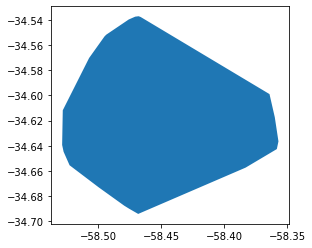

In [16]:
geo_data_ch = geo_data.unary_union.convex_hull
geopandas.GeoSeries([geo_data_ch]).plot();

### Gastronomia

In [42]:
%%time
pois = osmnx.geometries_from_polygon(
    geo_data_ch, tags={"amenity": ['restaurant', 'bar', 'biergarten', 'cafe', 'fast_food', 'food_court', 'ice_cream', 'pub']}
).reset_index()[["osmid", "amenity", "name", "cuisine", "name", "geometry"]]

/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 1.51 s, sys: 77.6 ms, total: 1.59 s
Wall time: 8.06 s


In [43]:
pois.groupby('amenity').amenity.count()

/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


amenity
bar            379
biergarten       5
cafe          1027
fast_food      729
food_court       1
ice_cream      346
pub            101
restaurant    2184
Name: amenity, dtype: int64

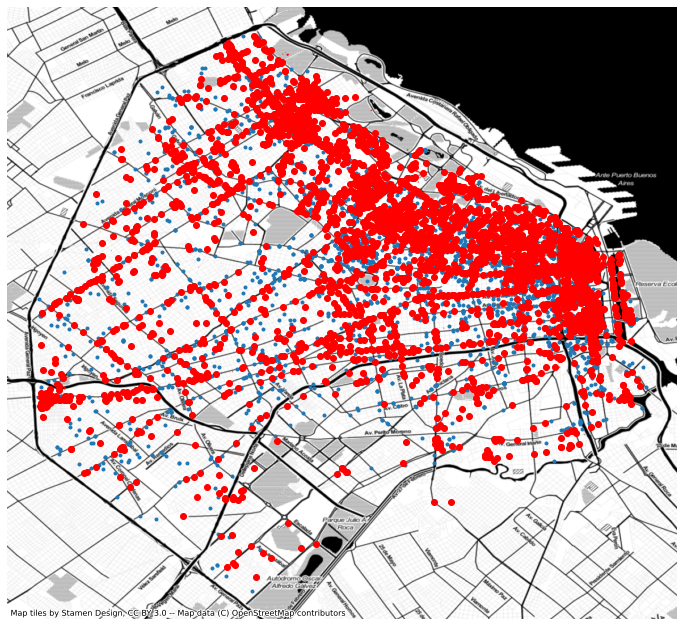

In [44]:
# Set up figure and axis
f,ax = plt.subplots(1,figsize=(12, 12))
# Plot AirBnb properties
geo_data.plot(ax=ax, marker='.')
# Plot POIs in red
pois.plot(ax=ax, color='r')
# Add Stamen's Toner basemap
contextily.add_basemap(
    ax, 
    crs=geo_data.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off()
# Display
plt.show()

In [33]:
geo_data_planar = geo_data.to_crs(epsg=3857)
pois_planar = pois.to_crs(epsg=3857)

/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
geo_data_planar['buffer_500m'] = geo_data_planar.buffer(500)

In [35]:
# Spatial join, appending attributes from right table to left one
joined = geopandas.sjoin(
    # Right table - POIs
    pois_planar,
    # Left table - Airbnb with the geometry reset from the original
    # points to the 500m buffer and selecting only `id` and
    # `buffer_500m` column
    geo_data_planar.set_geometry('buffer_500m')[['id', 'buffer_500m']],
    # Operation (spatial predicate) to use for the spatial join (`within`)
    op="within"
)

In [36]:
# Group POIs by Airbnb ID (`id`)
poi_count = joined.groupby(
    "id"
# Keep only POI id column (`osmid`)
)[
    "osmid"
# Count POIs by Airbnb + convert Series into DataFrame
].count().to_frame(
    'poi_count'
)
# Print top of the table
poi_count.head()

/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


poi_count
id           
1          17
2           1
4           1
5           1
6           2

In [37]:
geo_data_w_counts = geo_data_planar.merge(
    poi_count, left_on='id', right_index=True
).fillna({"poi_count": 0})

/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


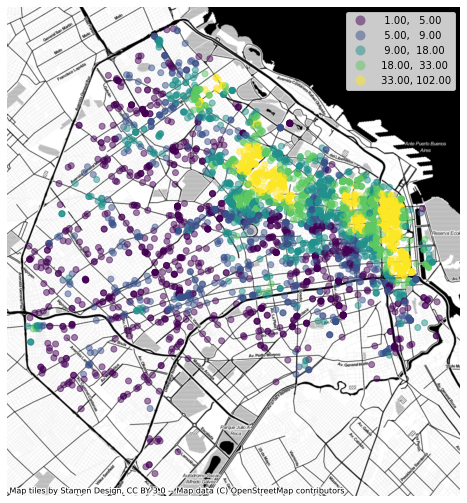

In [38]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot quantile map of No. of POIs for every Airbnb
geo_data_w_counts.plot(
    column="poi_count",
    scheme="quantiles",
    alpha=0.5,
    legend=True,
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=geo_data_planar.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off();

### Educación

In [51]:
%%time
pois_education = osmnx.geometries_from_polygon(
    geo_data_ch, tags={"amenity": ['college', 'kindergarten', 'library', 'language_school', 'school', 'university']}
).reset_index()[["osmid", "amenity", "name", "geometry"]]

/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 1.1 s, sys: 40.9 ms, total: 1.14 s
Wall time: 1.14 s


In [52]:
pois_education.groupby('amenity').amenity.count()

/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


amenity
college             369
kindergarten        781
language_school      11
library              85
school             1669
university           93
Name: amenity, dtype: int64

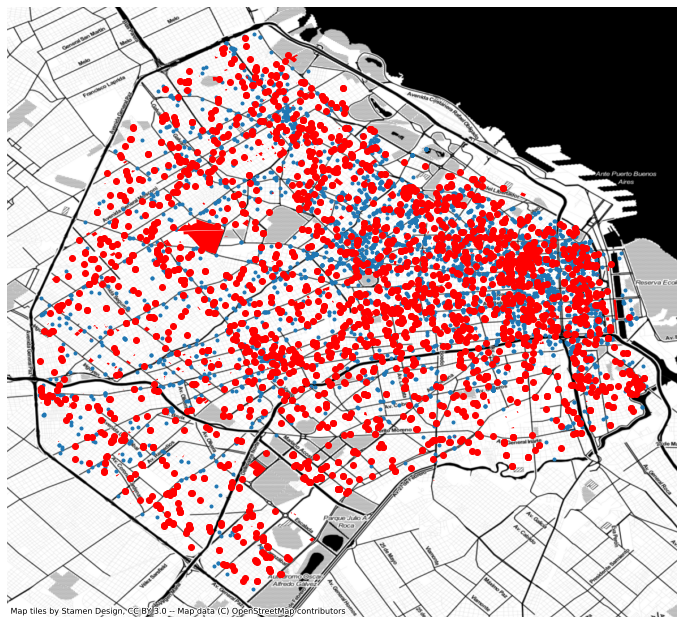

In [53]:
# Set up figure and axis
f,ax = plt.subplots(1,figsize=(12, 12))
# Plot AirBnb properties
geo_data.plot(ax=ax, marker='.')
# Plot POIs in red
pois_education.plot(ax=ax, color='r')
# Add Stamen's Toner basemap
contextily.add_basemap(
    ax, 
    crs=geo_data.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off()
# Display
plt.show()

In [54]:
geo_data_planar = geo_data.to_crs(epsg=3857)
pois_education_planar = pois_education.to_crs(epsg=3857)

/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
geo_data_planar['buffer_500m'] = geo_data_planar.buffer(500)

In [56]:
# Spatial join, appending attributes from right table to left one
joined = geopandas.sjoin(
    # Right table - POIs
    pois_education_planar,
    # Left table - Airbnb with the geometry reset from the original
    # points to the 500m buffer and selecting only `id` and
    # `buffer_500m` column
    geo_data_planar.set_geometry('buffer_500m')[['id', 'buffer_500m']],
    # Operation (spatial predicate) to use for the spatial join (`within`)
    op="within"
)

In [57]:
# Group POIs by Airbnb ID (`id`)
poi_count = joined.groupby(
    "id"
# Keep only POI id column (`osmid`)
)[
    "osmid"
# Count POIs by Airbnb + convert Series into DataFrame
].count().to_frame(
    'poi_count'
)
# Print top of the table
poi_count.head()

/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


poi_count
id           
1          16
3           3
4           3
5           3
6          12

In [58]:
geo_data_w_counts = geo_data_planar.merge(
    poi_count, left_on='id', right_index=True
).fillna({"poi_count": 0})

/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


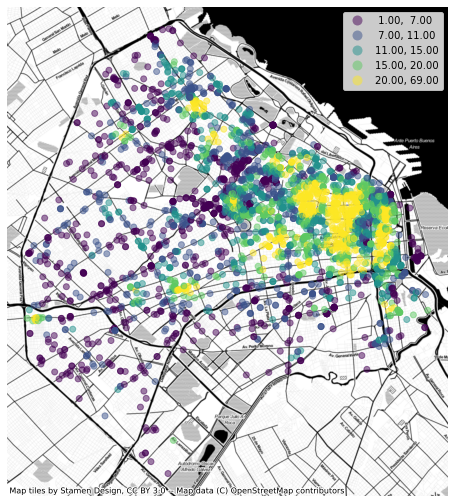

In [59]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot quantile map of No. of POIs for every Airbnb
geo_data_w_counts.plot(
    column="poi_count",
    scheme="quantiles",
    alpha=0.5,
    legend=True,
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=geo_data_planar.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off();

### Avenidas

In [69]:
%%time
pois_roads = osmnx.geometries_from_polygon(
    geo_data_ch, tags={"highway": ['trunk', 'primary']}
).reset_index()#[["osmid", "amenity", "name", "cuisine", "name", "geometry"]]

/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 1.05 s, sys: 41.7 ms, total: 1.09 s
Wall time: 6.79 s


In [70]:
pois_roads.head()

/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


element_type     osmid  highway  \
0          way  10616672  primary   
1          way  17441481  primary   
2          way  17442200  primary   
3          way  17448289  primary   
4          way  18793046  primary   

                                            geometry source  \
0  LINESTRING (-58.44479 -34.58452, -58.44491 -34...    NaN   
1  LINESTRING (-58.41093 -34.57679, -58.41085 -34...    NaN   
2  LINESTRING (-58.37345 -34.60844, -58.37370 -34...    NaN   
3  LINESTRING (-58.41680 -34.57415, -58.41606 -34...    NaN   
4  LINESTRING (-58.48607 -34.64659, -58.48535 -34...    NaN   

                     name     bicycle lanes  surface maxspeed  ...  \
0         Avenida Córdoba  designated     4  asphalt       60  ...   
1  Avenida Del Libertador         NaN    12  asphalt       70  ...   
2         Avenida de Mayo         NaN   NaN  asphalt       60  ...   
3  Avenida Del Libertador         NaN     4  asphalt       60  ...   
4      Avenida Directorio         NaN   NaN  asphalt       60  ...   

  cycleway:right surface:lanes access:lanes lanes:bus cutting turn:lanes  \
0            NaN           NaN          NaN       NaN     NaN        NaN   
1            NaN           NaN          NaN       NaN     NaN        NaN   
2            NaN           NaN          NaN       NaN     NaN        NaN   
3            NaN           NaN          NaN       NaN     NaN        NaN   
4            NaN           NaN          NaN       NaN     NaN        NaN   

  noname maxspeed:conditional destination covered  
0    NaN                  NaN         NaN     NaN  
1    NaN                  NaN         NaN     NaN  
2    NaN                  NaN         NaN     NaN  
3    NaN                  NaN         NaN     NaN  
4    NaN                  NaN         NaN     NaN  

[5 rows x 68 columns]

In [71]:
pois_roads.groupby('highway').highway.count()

/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


highway
primary    860
trunk       52
Name: highway, dtype: int64

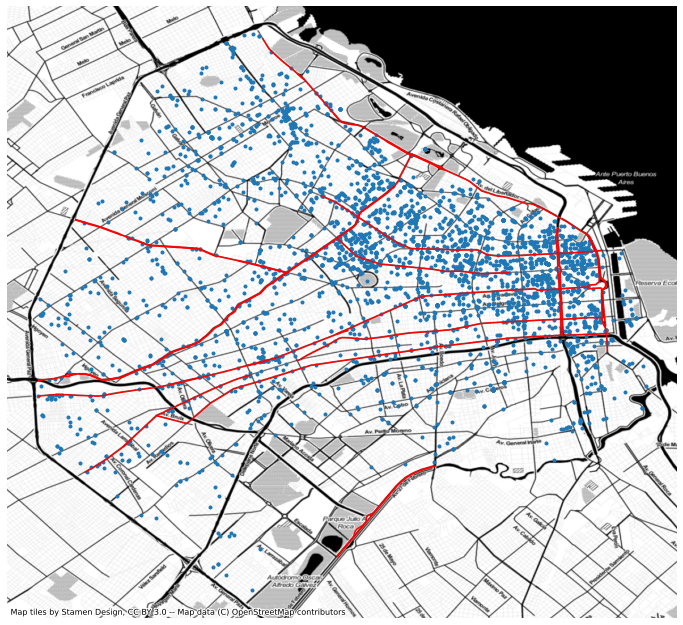

In [72]:
# Set up figure and axis
f,ax = plt.subplots(1,figsize=(12, 12))
# Plot AirBnb properties
geo_data.plot(ax=ax, marker='.')
# Plot POIs in red
pois_roads.plot(ax=ax, color='r')
# Add Stamen's Toner basemap
contextily.add_basemap(
    ax, 
    crs=geo_data.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off()
# Display
plt.show()

In [73]:
geo_data_planar = geo_data.to_crs(epsg=3857)
pois_roads_planar = pois_roads.to_crs(epsg=3857)

/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
geo_data_planar['buffer_500m'] = geo_data_planar.buffer(500)

In [75]:
# Spatial join, appending attributes from right table to left one
joined = geopandas.sjoin(
    # Right table - POIs
    pois_roads_planar,
    # Left table - Airbnb with the geometry reset from the original
    # points to the 500m buffer and selecting only `id` and
    # `buffer_500m` column
    geo_data_planar.set_geometry('buffer_500m')[['id', 'buffer_500m']],
    # Operation (spatial predicate) to use for the spatial join (`within`)
    op="within"
)

In [76]:
# Group POIs by Airbnb ID (`id`)
poi_count = joined.groupby(
    "id"
# Keep only POI id column (`osmid`)
)[
    "osmid"
# Count POIs by Airbnb + convert Series into DataFrame
].count().to_frame(
    'poi_count'
)
# Print top of the table
poi_count.head()

/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


poi_count
id           
1           7
6          13
11          9
13          9
14         11

In [77]:
geo_data_w_counts = geo_data_planar.merge(
    poi_count, left_on='id', right_index=True
).fillna({"poi_count": 0})

/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


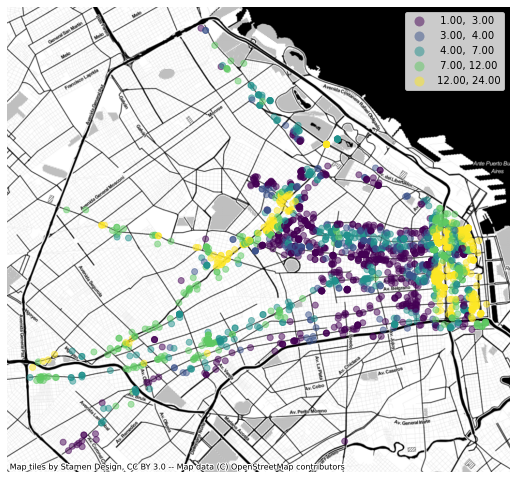

In [78]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot quantile map of No. of POIs for every Airbnb
geo_data_w_counts.plot(
    column="poi_count",
    scheme="quantiles",
    alpha=0.5,
    legend=True,
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=geo_data_planar.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off();

### Map Synthesis

In [79]:
# Build distance band spatial weights matrix
d500_w = weights.DistanceBand.from_dataframe(
    geo_data_planar, threshold=500, silence_warnings=True
)

/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [80]:
card = pandas.Series(d500_w.cardinalities)

/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


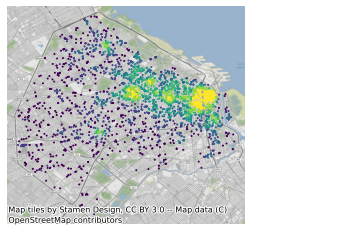

In [83]:
# Set up figure and axis
f, ax = plt.subplots(1)
# Append cardinalities to main Airbnb geo-table
geo_data.assign(
    card=card
# Plot cardinality quantile choropleth
).plot('card', scheme='quantiles', k=7, markersize=1, ax=ax)
# Add basemap
contextily.add_basemap(ax, crs=geo_data.crs)
# Remove axes
ax.set_axis_off();

In [86]:
# Row standardise
d500_w.transform = 'r'
# Compute spatial lag of surface of each shop
local_average_surface = weights.lag_spatial(
    d500_w, geo_data_planar[['m2total']].values
)

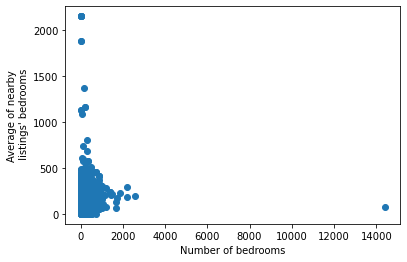

In [87]:
plt.scatter(geo_data_planar[['m2total']].values, local_average_bedrooms)
plt.xlabel("Number of bedrooms")
plt.ylabel("Average of nearby\n listings' bedrooms");

##### Band buffer

In [129]:
average_within_500 = weights.lag_spatial(
    d500_w, geo_data_planar[['m2total']].values
)

/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [130]:
d1k_w = weights.DistanceBand.from_dataframe(
    geo_data_planar, threshold=1000, silence_warnings=True
)

In [131]:
d1k_exclusive = weights.set_operations.w_difference(
    d1k_w, d500_w, constrained=False
)

/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 21 disconnected components.
 There are 18 islands with ids: 142, 176, 391, 392, 403, 440, 1309, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 3406, 3417, 3686.
  warnings.warn(message)


In [132]:
d1k_exclusive.transform = 'r'
average_500m_to_1k = weights.lag_spatial(
    d1k_exclusive, geo_data_planar[['m2total']].values
)

('WARNING: ', 142, ' is an island (no neighbors)')
('WARNING: ', 176, ' is an island (no neighbors)')
('WARNING: ', 391, ' is an island (no neighbors)')
('WARNING: ', 392, ' is an island (no neighbors)')
('WARNING: ', 403, ' is an island (no neighbors)')
('WARNING: ', 440, ' is an island (no neighbors)')
('WARNING: ', 1309, ' is an island (no neighbors)')
('WARNING: ', 1777, ' is an island (no neighbors)')
('WARNING: ', 1778, ' is an island (no neighbors)')
('WARNING: ', 1779, ' is an island (no neighbors)')
('WARNING: ', 1780, ' is an island (no neighbors)')
('WARNING: ', 1781, ' is an island (no neighbors)')
('WARNING: ', 1782, ' is an island (no neighbors)')
('WARNING: ', 1783, ' is an island (no neighbors)')
('WARNING: ', 1784, ' is an island (no neighbors)')
('WARNING: ', 3406, ' is an island (no neighbors)')
('WARNING: ', 3417, ' is an island (no neighbors)')
('WARNING: ', 3686, ' is an island (no neighbors)')


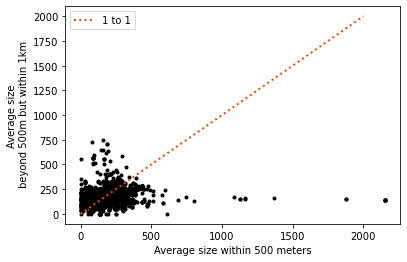

In [134]:
# Plot scatter
plt.scatter(
    average_within_500,
    average_500m_to_1k,
    color='k', marker='.'
)
# Rename horizontal axis
plt.xlabel("Average size within 500 meters")
# Rename vertical axis
plt.ylabel("Average size\n beyond 500m but within 1km")
# Plot line of 45 degrees
plt.plot(
    [0,2000],
    [0,2000], 
    color='orangered', 
    linestyle=':', 
    linewidth=2, 
    label='1 to 1'
)
# Add legend
plt.legend();

In [128]:
geo_data_planar.head()

/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id  antig  m2total  m2cub  ambientes  banios             direccion  \
0   1      0      200    200          0       0  Gral Paz y Rivadavia   
1   2     30       50     50          0       1              Asuncion   
2   3     30      414    414          0       2    Avenida Beiro 5574   
3   4     35      414    414          0       2    Avenida Beiro 5574   
4   5     35      285    285          0       1    Avenida Beiro 5574   

         barrio  comuna    latitud  ...  precioUSD  m2precioUSD  \
0       LINIERS       9 -34.639300  ...    1500000  7500.000000   
1  VILLA DEVOTO      11 -34.611807  ...     125000  2500.000000   
2    VILLA REAL      10 -34.616468  ...     590000  1425.120773   
3    VILLA REAL      10 -34.616344  ...     730000  1763.000000   
4    VILLA REAL      10 -34.616344  ...     550000  1929.000000   

   comisaria_dista  obelisco_dista  nrobos  sup_espacio_verde  \
0      1162.621600    14053.797191     134          68426.445   
1      1887.227055    13473.139375      23         110997.543   
2      1497.020434    13514.662463      33         115341.039   
3      1506.066814    13495.631683      33         115500.289   
4      1506.066814    13495.631683      33         115500.289   

   count_gastronomia  count_culturales                           geometry  \
0                 12                 0  POINT (-6515379.181 -4114970.854)   
1                  3                 0  POINT (-6515322.519 -4111251.605)   
2                  5                 0  POINT (-6515319.514 -4111882.057)   
3                  5                 0  POINT (-6515298.029 -4111865.284)   
4                  5                 0  POINT (-6515298.029 -4111865.284)   

                                         buffer_500m  
0  POLYGON ((-6514879.181 -4114970.854, -6514881....  
1  POLYGON ((-6514822.519 -4111251.605, -6514824....  
2  POLYGON ((-6514819.514 -4111882.057, -6514821....  
3  POLYGON ((-6514798.029 -4111865.284, -6514800....  
4  POLYGON ((-6514798.029 -4111865.284, -6514800....  

[5 rows x 21 columns]

##### Clustering

In [92]:
from hdbscan import HDBSCAN

In [93]:
coordinates = numpy.column_stack(
    (geo_data_planar.geometry.x, geo_data_planar.geometry.y)
)

In [114]:
labels = HDBSCAN(min_cluster_size = 20).fit(coordinates).labels_

/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/hdbscan/hdbscan_.py:275: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  alg = KDTreeBoruvkaAlgorithm(tree, min_samples, metric=metric,
/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/hdbscan/hdbscan_.py:56: DeprecationWarni

In [115]:
hulls = geo_data_planar[['geometry']].dissolve(by=labels).convex_hull

/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/geopandas/geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return s


/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


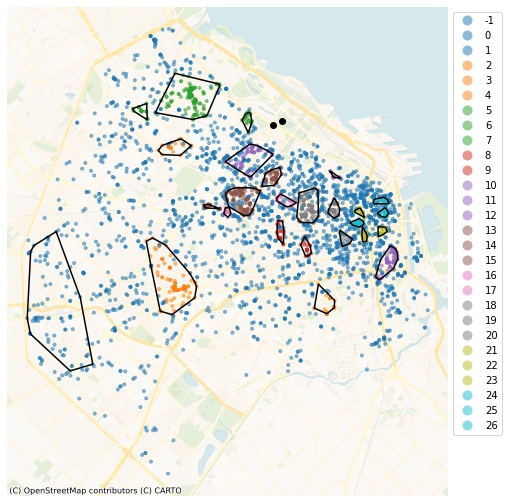

In [116]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot individual Airbnb locations
geo_data_planar.plot(
    # Colour by cluster label
    column=labels,
    # Consider label as categorical
    categorical=True,
    # Add 50% of transparency
    alpha=0.5,
    # Include legend
    legend=True,
    # Draw on axis `ax`
    ax=ax, 
    # Use circle as marker
    marker='.',
    # Position legend outside the map
    legend_kwds={'bbox_to_anchor': (1,1)}
)
# Plot convex hull polygons for each cluster label
# except that for -1 (observations classified as noise)
hulls[hulls.index != -1].boundary.plot(color='k', ax=ax)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=geo_data_planar.crs.to_string(), 
    source=contextily.providers.CartoDB.VoyagerNoLabels
)
# Remove axes
ax.set_axis_off();

/Users/alessiobocco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


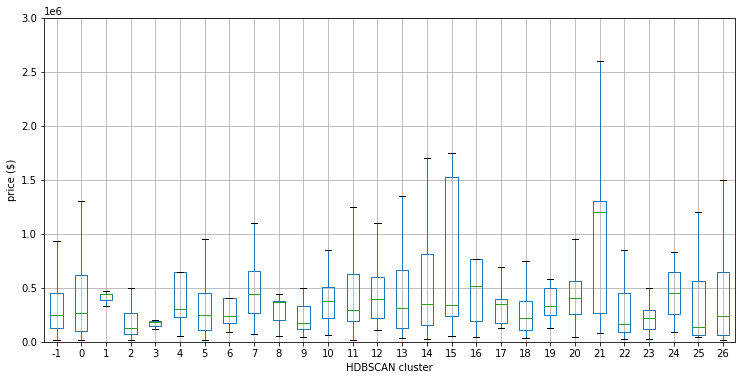

In [127]:
# Set up figure
f = plt.figure(figsize=(12,6))
# Add box plots of price by HDBSCAN cluster
ax = geo_data_planar.boxplot(
    # Plot distribution of 'price'
    "precioUSD", 
    # Group by cluster label, generating one box plot/cluster
    by=labels, 
    # Do not display individual outlier observations
    flierprops=dict(marker=None), 
    # Draw visualisation on the current axis (inside `f`)
    ax=plt.gca()
)
# Set label for horizontal axis
ax.set_xlabel("HDBSCAN cluster")
# Set labels for vertical axis
ax.set_ylabel("price ($)")

# Remove default figure title
plt.gcf().suptitle(None)
# Remove default axis title
ax.set_title(None)
# Re-adjust vertical value range for easier legibility
ax.set_ylim(0,3000000);